In [1]:
import numpy as np
import sobol_seq
import matplotlib.pyplot as plt
from functools import partial
from typing import List, Optional, Callable, Tuple


In [54]:
NP = 100 # number of population
gen_max = 100 # maximum number of fitness evaluation
# F = 0.3 # mutation factor
# CR = 0.7 # crossover rate
Hm = 50 # maximum number of historical memories

# theta = 1e-3
tau_d = 0.4 # distance radius
s_max = 6 # maximum archive size

F_init = 0.9
CR_init = 0.3

num_l = 20 # number of individuals in a subpopulation (cluster size)

dim = 2
boundaries = np.array([(-10,10) for _ in range (dim)])

def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])

def theta_increment(x):
    return 1/(np.exp(x))

In [55]:
def root_objective_function(x:np.ndarray):
    res = 0
    F_array = objective_function(x)
    for f in F_array:
        res +=(f)**2
    return res

#### Used repulsion function

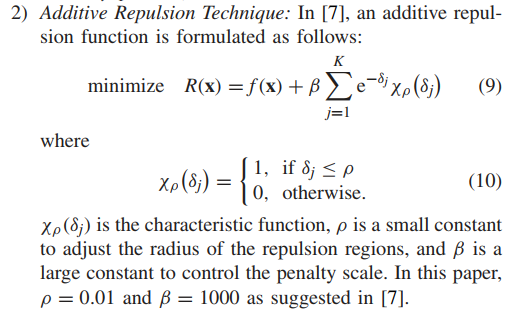

In [5]:
"""Characteristic Function"""
def chi_p(delta_j, rho):
    return 1 if delta_j <= rho else 0

"""Repulsion Function"""
def repulsion_function(x,
                       archive,
                       objective_func=root_objective_function,
                       beta=100,
                       rho=1e-8):
    f_x = objective_func(x)
    Rx = 0
    for x_star in archive:
        delta_j = np.linalg.norm(x-x_star)
        Rx += np.exp(-delta_j) * chi_p(delta_j, rho)
    Rx *= beta
    Rx += f_x
    return Rx

"""Fitness Function"""
def fitness_function(x,
                     archive,
                     objective_func=root_objective_function,
                     repulsion_func=repulsion_function):
    f_x = objective_func(x)
    if archive == []:
        return f_x
    else:
        return repulsion_func(x,archive)
    
# # Test the Functiuons
# arch = [np.array([1,2]),np.array([3,4]),np.array([-6.43,0.15])]
# x = np.array([-6.437160,0.155348])
# print(fitness_function(x,
#                        arch,
#                        objective_func=root_objective_function,
#                        repulsion_func=partial(repulsion_function,
#                                               objective_func = root_objective_function,
#                                               beta=1000,rho=0.01)))

In [74]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim: int,
                    npoint:int,
                    low=-10,
                    high=10,
                    sobol = True):
    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')
    if type(low) == int:
        boundaries = [(low,high) for _ in range (dim)]
    elif type(low) == list or type(low) == np.ndarray:
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i],high[i]) for i in range (len(low))]

    if sobol == True:
        # Generate Sobol sequence points
        sobol_points = sobol_seq.i4_sobol_generate(dim, npoint)
        # Scale the Sobol points to fit within the specified boundaries
        scaled_points = []
        for i in range(dim):
            a, b = boundaries[i]
            scaled_dim = a + sobol_points[:, i] * (b - a)
            scaled_points.append(scaled_dim)
        # Transpose the scaled points to get points per dimension
        scaled_points = np.array(list(map(list, zip(*scaled_points))))
    
    else:
        scaled_points = np.zeros((NP, dim))
        for i in range(dim):
            min_val, max_val = boundaries[i]
            scaled_points[:, i] = np.random.uniform(min_val, max_val, NP)

    return scaled_points


Archive Updating

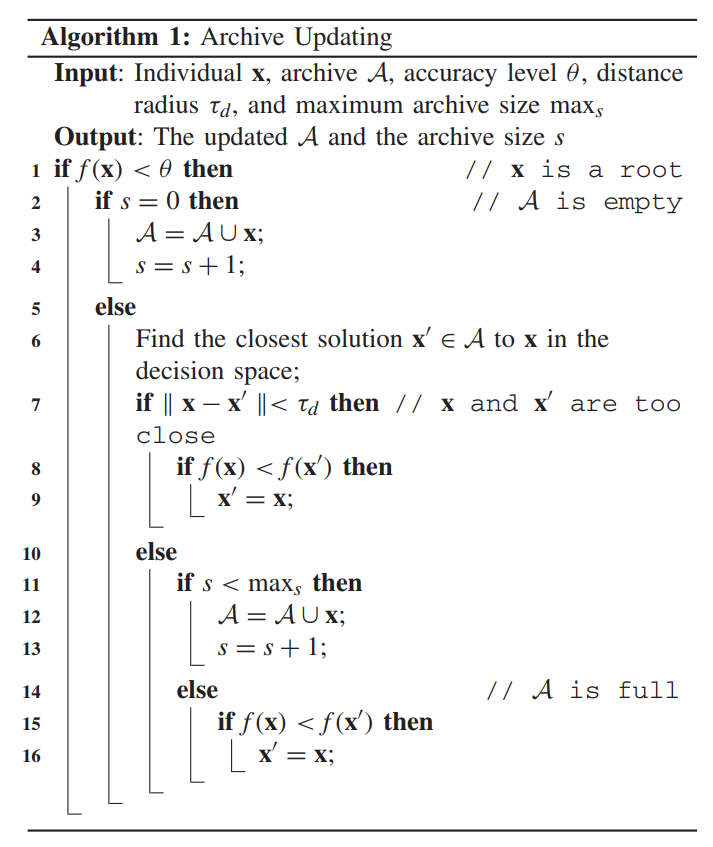

In [7]:
def update_archive(x: np.ndarray,
                   objective_function,
                   archive,
                   theta,
                   tau_d,
                   s_max):
    """Input"""
    # x : Individual
    # theta : accuracy level
    # tau_d : distance radius
    # s_max : maximum archive size
    # archive : archive
    # s : archive current size

    f_x = objective_function(x)
    s = len(archive) # archive current size
    if f_x < theta: # x is a root
        # print(f'f({x})= {f_x}')
        if s == 0: # archive is empty
            archive.append(x)
            s+=1
        else:
            """Find the closest solution x_prime ∈ archive to x in the decision space"""
            dist_min = np.linalg.norm(x-archive[0])
            idx_min = 0
            x_prime= archive[idx_min]
            for i in range(1,len(archive)): 
                dist = np.linalg.norm(x-archive[i])
                if dist < dist_min:
                    dist_min = dist
                    x_prime = archive[i]
                    idx_min = i
            f_x_prime = root_objective_function(x_prime)
            if dist_min < tau_d: # x and x_prime are too close
                if f_x < f_x_prime:
                    x_prime = x
                    archive[idx_min] = x_prime
            else:
                if s < s_max:
                    archive.append(x)
                    s += 1
                else:       # archive is full
                    if f_x<f_x_prime:
                        x_prime = x
                        archive[idx_min] = x_prime
    return archive


# # Test the function
# x = np.array([-6.437160,0.155348]) # Individual
# theta = 1e-4 # accuracy level
# tau_d = 1e-1 # distance radius
# s_max = 3 # maximum archive size
# archive = [np.array([0,0]),np.array([1,2]),np.array([-6.4,0])] # archive
# update_archive(x,root_objective_function,archive,theta,tau_d,s_max)

In [8]:
def mutation(xr1,xr2,xr3,scaling_factor):
    donor_vector = xr1 + scaling_factor*(xr2-xr3)
    return donor_vector

def crossover(individual:np.ndarray, honor_vector:np.ndarray, crossover_rate):
    trial_vector = np.zeros(shape=individual.shape)
    for j in range (individual.shape[0]):
        rand_j = np.random.random() # a uniformly distributed random number from [0, 1]
        j_rand = np.random.randint(dim+1) #a random integer uniformly generated from {1, . . . , n}
        if (rand_j<crossover_rate) or (j == j_rand):
            trial_vector[j] = honor_vector[j]
        else: #(rand_j>=CR) and (j != j_rand)
            trial_vector[j] = individual[j]
    return trial_vector


## Mutation Penalty 

Midpoint Target

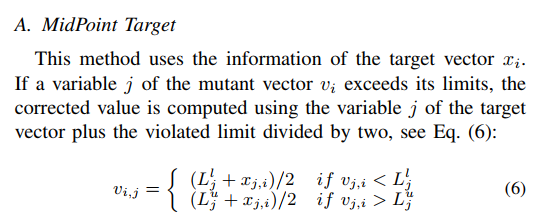

Reflection

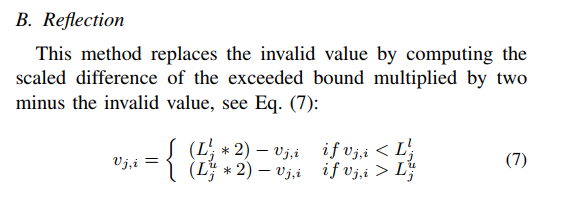

In [58]:
def mutation_penalty(x_i, subpop_i, boundaries, scaling_factor):
    """GENERATE: three distinct individuals xr1, xr1, xr1 from the current population randomly"""
    subpop_i_copy = subpop_i.copy()
    pop_ids = np.arange(subpop_i_copy.shape[0])
    indices_to_delete = np.where(np.all(subpop_i_copy == x_i, axis=1))[0] # Ensure that x_i is excluded from the selected subpopulation
    subpop_ids_no_i = np.delete(pop_ids, indices_to_delete, axis=0)
    xr1,xr2,xr3 = subpop_i_copy[np.random.choice(subpop_ids_no_i,3,replace=False)] 

    """MUTATION: Form the donor/mutation vector"""
    dv_i = mutation(xr1,xr2,xr3,scaling_factor)

    """Set penalty for every donor vector that violates the boundaries"""
    for j in range (len(dv_i)):
        if dv_i[j] < boundaries[j,0]:
            dv_i[j] = (x_i[j]+boundaries[j,0])/2
        elif dv_i[j] > boundaries[j,1]:
            dv_i[j] = (x_i[j]+boundaries[j,1])/2
    return dv_i
        

In [63]:
"""Calculate Euclidean distances and select t closest individuals"""
def subpopulating(individual, 
                  population, 
                  t,
                  return_index = False,
                  show_distances = False): 
    """Input"""
    # individual
    # population
    # t: max number of units in a subpopulation

    """Algorithm"""
    # Calculate the Euclidean distances from the individual to all others in the population
    distances = np.sqrt(np.sum((population - individual) ** 2, axis=1))
    # Get the indices of the individuals with the smallest distances
    closest_indices = np.argsort(distances)[:t]
    # Form the subpopulation with the closest individuals
    subpop = population[closest_indices]

    if show_distances == True:
        print(f'Distance: \n{distances[:t]}')
    if return_index == True:
        if t == 1:
            return closest_indices,subpop.flatten()
        else:
            return closest_indices,subpop
    else:
        if t == 1:
            return subpop.flatten()
        else:
            return subpop

# # Test the function
# # Assuming P is a numpy array of individuals where each individual is a point in n-dimensional space
# np.random.seed(0)
# P = np.random.rand(100, 2)  # Example: 100 individuals in a 2-dimensional space
# # print(f"P:{P}")
# print("")

# # The number of individuals to select with the smallest Euclidean distances
# t = 2
# # Forming subpopulations for each individual in P
# subpopulations = [subpopulating(xi, P, t) for xi in P]
# # print(f"subpopulations:{subpopulations}")
# print("")

# # Now subpopulations is a list of numpy arrays, each containing the t closest individuals to each xi in P (including xi itself)
# # For example, to access the subpopulation for the first individual in P:
# subpopulation_first_individual = subpopulations[0]
# print(f"subpopulation_first_individual:{subpopulation_first_individual}")

# [id1,id2],[v1,v2] = subpopulating(P[0],P,t,show_distances=True,return_index=True)
# v1,v2

In [12]:
def update_parameter(M_F,
                     M_CR,
                     Hm:int):
    """Input"""
    # MF: Historical memories of scaling factor of DE as F
    # MCR:Historical memories crossover rate of DE as CR
    # Hm: Size of Historical Memories

    # Randomly select an index
    hi = np.random.randint(0, Hm)
    # Generate Fi using the Cauchy distribution with the location parameter MF[hi] and scale 0.1
    Fi = np.random.standard_cauchy() * 0.1 + M_F[hi]
    # Generate CRi using the Gaussian distribution with mean MCR[hi] and standard deviation 0.1
    CRi = np.random.normal(M_CR[hi], 0.1)
    # Ensure CRi is within the range [0, 1] and Fi is within the range [0,2]
    Fi = np.clip(Fi, 0, 1)
    CRi = np.clip(CRi, 0, 1)
    return Fi, CRi

# # Coba
# MF = [0.5, 0.6, 0.7, 0.8, 0.9] 
# MCR = [0.1, 0.2, 0.3, 0.4, 0.5]
# update_parameter(MF,MCR,len(MF))

In [13]:
def meanWL(elements, weights):
    """
    Calculate the weighted Lehmer mean of elements.
    Lehmer mean is calculated as the weighted sum of the squares
    divided by the weighted sum of the elements.
    """
    numerator = np.sum(np.multiply(np.square(elements), weights))
    denominator = np.sum(np.multiply(elements, weights))
    return numerator / denominator if denominator != 0 else 0

# Define the weighted arithmetic mean function
def meanWA(elements, weights):
    """
    Calculate the weighted arithmetic mean of elements.
    This is the standard weighted mean.
    """
    return np.average(elements, weights=weights)

def update_history(M_F,M_CR,S_F,S_CR,k):
    weights = np.array([1 for _ in range (len(S_F))])
    if len(S_F)!=0:
        M_F[k] = meanWL(S_F,weights) 
    if len(S_CR)!=0:
        M_CR[k] = meanWA(S_CR,weights)
    return M_F,M_CR


In [14]:
popA = generate_points(dim=dim,
                        npoint=NP,
                        low=boundaries[:,0],
                        high=boundaries[:,1],
                        sobol=True)
f_x = root_objective_function([popA[:,0],popA[:,1]])
M_CR = np.ones(Hm)*CR_init
M_F = np.ones(Hm)*F_init
archiveA = []
gen = 0
k = 0

#### Framework of RADE

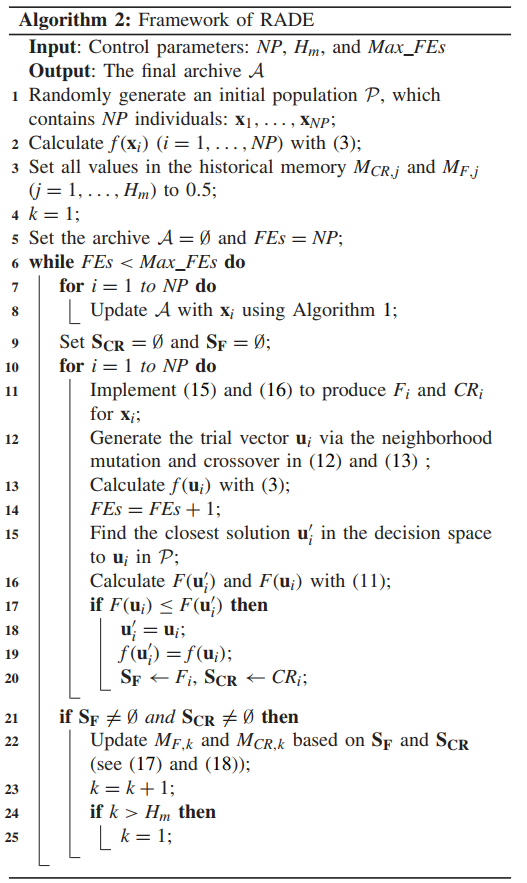

In [15]:
np.random.seed(90)
# theta = 0
while gen < gen_max:
    print(f'===== GENERATION {gen} =====')
    popB = popA.copy()
    theta = 1e-7
    for i in range (NP):
        # print(theta_increment(theta))
        # print(f'x={popA[i]}')
        archiveA = update_archive(x = popA[i],
                                  objective_function=root_objective_function,
                                  archive=archiveA,
                                  theta=theta,
                                  tau_d=tau_d,
                                  s_max=s_max)
        # theta *=0.7
    print(f'archive= {archiveA}')
    S_F, S_CR = [],[]
    subpopA = np.array([subpopulating(xi, popA, num_l) for xi in popA])
    for i in range (NP):
        F_i,CR_i = update_parameter(M_F,M_CR,Hm)
        """MUTATION: Form the donor/mutation vector and penalize it if it violates the boundaries"""
        x_i = popA[i]
        dv_i = mutation_penalty(x_i,subpopA[i],boundaries,F_i)

        """CROSSOVER: The trial vector dv_i is developed either from the elements of the target vector xi or the elements of the donor vector vi"""
        tv_i = crossover(x_i,dv_i,CR_i)

        """Calculate root_objective_function on the trial function tv_i"""
        f_tv_i = root_objective_function(tv_i)

        # """Add iteration for fitness function evaluation"""
        # FEs +=1

        """Find the closest solution tv_i_prime in the decision space to tv_i in PopA"""
        # [candid_tv_i_prime_1,candid_tv_i_prime_2],[cand_tv_i_prime_1,cand_tv_i_prime_2] = subpopulating(tv_i,popA,2,show_distances=False,return_index=True)
        # if np.array_equal(tv_i, cand_tv_i_prime_1):
        #     tv_i_prime = cand_tv_i_prime_2
        #     id_tv_i_prime = candid_tv_i_prime_2
        # else: # tv_i != cand_tv_i_prime_1
        #     tv_i_prime = cand_tv_i_prime_1
        #     id_tv_i_prime = candid_tv_i_prime_1
        id_tv_i_prime,tv_i_prime = subpopulating(tv_i,popA,1,show_distances=False,return_index=True)
        # print(f'i={i}\ntv_i: {tv_i}\nf_tv_i: {f_tv_i}\ntv_i_prime: {tv_i_prime}\nid_tv_i_prime: {id_tv_i_prime}\n')
        F_tv_i = fitness_function(tv_i,
                                archiveA,
                                objective_func=root_objective_function,
                                repulsion_func=partial(repulsion_function,
                                                        objective_func = root_objective_function,
                                                        beta=1000,rho=0.01))
        F_tv_i_prime = fitness_function(tv_i_prime,
                                        archiveA,
                                        objective_func=root_objective_function,
                                        repulsion_func=partial(repulsion_function,
                                                               objective_func = root_objective_function,
                                                               beta=1000,rho=0.01))
        # print(f'F_tv_i: {F_tv_i}\nF_tv_i_prime: {F_tv_i_prime}')
        if F_tv_i <= F_tv_i_prime:
            popA[id_tv_i_prime] = tv_i
            # print(f'F_tv_i={F_tv_i}<F_tv_i_prime={F_tv_i_prime}')
            S_F.append(F_i)
            S_CR.append(CR_i)

    # print(f'S_F: {S_F}\nS_CR: {S_CR}')
    """Update parameter history"""
    if (len(S_F)!=0) & (len(S_CR)!=0):
        M_F,M_CR = update_history(M_F,M_CR,S_F,S_CR,k)
        # print(f'M_F: {M_F}\nM_CR: {M_CR}')
        k +=1
        if k >= Hm:
            k = 1
    print(popA == popB)
    gen += 1

print(f'M_F: {M_F}\nM_CR: {M_CR}')
print(f'Archive: {archiveA}')

===== GENERATION 0 =====
archive= []
[[ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True False]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False  True]
 [ True  True]
 [False False]
 [False False]
 [ True  True]
 [ True False]
 [False False]
 [ True  True]
 [ True  True]
 [False False]
 [False  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [False False]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [False False]
 [ True  True]
 [False False]
 [F

[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [False False]
 [False False]
 [ True  True]
 [ True  True]
 [False False]
 [False False]
 [ True  True]
 [False False]
 [ True  True]
 [False False]
 [ True  True]
 [ True False]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  T

In [16]:
popA = generate_points(dim=dim,
                        npoint=NP,
                        low=boundaries[:,0],
                        high=boundaries[:,1])

M_CR = np.ones(Hm)*CR_init
M_F = np.ones(Hm)*F_init

subpopA = np.array([subpopulating(xi, popA, num_l) for xi in popA])

In [18]:
np.random.seed(4)
i = 1
F_i,CR_i = update_parameter(M_F,M_CR,Hm)
x_i = popA[i]
dv_i = mutation_penalty(x_i,subpopA[i],boundaries,F_i)
tv_i = crossover(x_i,dv_i,CR_i)
tv_i

array([ 7.5, -5. ])

In [72]:
import numpy as np

# Define your objective function that you want to optimize
def OBJ_FUN(x):
    # Replace with your own objective function
    return np.sum(x**2)

# Initialization function for the population
def initialize_population(pop_size, dimensions, bounds):
    population = np.random.rand(pop_size, dimensions)
    lower_bounds, upper_bounds = np.asarray(bounds).T
    diff = np.fabs(lower_bounds - upper_bounds)
    return lower_bounds + population * diff

# Mutation function for DE
def mutate(population, F):
    # Vectorized mutation operation
    indices = np.arange(population.shape[0])
    np.random.shuffle(indices)
    r1, r2, r3 = population[indices[:3]]
    mutant = r1 + F * (r2 - r3)
    return mutant

def crossover(target, mutant, CR):
    cross_points = np.random.random(target.shape) < CR
    # Ensure at least one true crossover point
    if not np.any(cross_points):
        cross_points[np.random.randint(0, target.shape[0])] = True
    trial = np.where(cross_points, mutant, target)
    return trial

# Repulsion function to avoid premature convergence (simplified version)
def repulsion(population, repulsion_factor):
    # This is a placeholder for the repulsion mechanism
    # The actual implementation would involve calculating the distances between individuals
    # and applying a repulsion force to increase diversity.
    return population + repulsion_factor * (np.random.rand(*population.shape) - 0.5)

# Main RADE algorithm loop
def RADE(objective, bounds, pop_size, max_gen, F, CR):
    dimensions = len(bounds)
    population = initialize_population(pop_size, dimensions, bounds)
    fitness = np.asarray([objective(ind) for ind in population])
    best_idx = np.argmin(fitness)
    best = population[best_idx]
    
    for gen in range(max_gen):
        for i in range(pop_size):
            mutant = mutate(population, F)
            trial = crossover(population[i], mutant, CR)
            trial_fitness = objective(trial)
            
            if trial_fitness < fitness[i]:
                fitness[i] = trial_fitness
                population[i] = trial
                if trial_fitness < fitness[best_idx]:
                    best_idx = i
                    best = trial

        # Apply repulsion at certain intervals or based on a condition
        if gen % 10 == 0:  # Example condition
            population = repulsion(population, repulsion_factor=0.1)

        print(f"=========Generation {gen}=========")
        print(f"Best Fitness: {fitness[best_idx]}")
    
    return best, fitness[best_idx]

# Example usage:
bounds = np.array([(-10,10) for _ in range (2)])
best_solution, best_fitness = RADE(root_objective_function, bounds, pop_size=100, max_gen=1000, F=0.8, CR=0.9)
print("Best Solution:", best_solution)
print("Best Fitness:", best_fitness)


mutant:[16.10599413  5.33001228]
mutant:[-4.48525993  5.26738964]
mutant:[-8.57862064 -6.50423491]
mutant:[  4.66573847 -18.08702666]
mutant:[-1.64809834 -2.12946601]
mutant:[13.33406563 -4.32045404]
mutant:[-4.92238682  6.66609851]
mutant:[-8.10571966 -0.30285598]
mutant:[-7.39339908 23.67860264]
mutant:[ 5.71823948 13.35146385]
mutant:[ 0.02831723 -5.69764438]
mutant:[9.21970309 7.22435603]
mutant:[-7.83095557  8.52659963]
mutant:[ -4.92142613 -11.8514719 ]
mutant:[ 2.47580981 -4.16619935]
mutant:[  3.69528484 -12.38279053]
mutant:[4.98125277 2.96054307]
mutant:[8.95237692 7.80738448]
mutant:[-11.96564368  -8.05614496]
mutant:[2.511835   8.23572804]
mutant:[-1.77397206 10.59824076]
mutant:[ 0.30641217 -1.58666472]
mutant:[ 9.49372461 11.62985948]
mutant:[-5.63461684 -0.54780026]
mutant:[14.31427064  8.40345571]
mutant:[-1.45290078 -3.47881245]
mutant:[-4.40278614  0.16601179]
mutant:[-1.45565742 -3.14507832]
mutant:[-1.11942447 -6.04681751]
mutant:[5.42597846 3.21253376]
mutant:[ 0.0

mutant:[-3.42757971  8.09322636]
mutant:[-0.50504702 -3.83837513]
mutant:[0.42090143 5.49282262]
mutant:[-4.10052411 -2.15255573]
mutant:[-1.63971956  9.31522691]
mutant:[-3.86345353 -0.28219258]
mutant:[-0.49605432  2.29554908]
mutant:[-4.70531107  6.7471994 ]
mutant:[-3.72394405 -1.94503362]
mutant:[-0.06285706  0.74567991]
mutant:[0.53267437 1.5928928 ]
mutant:[-4.6140173   0.17010961]
mutant:[-4.99276467 -0.12056879]
mutant:[-0.65306335 10.47012581]
mutant:[-2.0003186   0.60643122]
mutant:[-0.3417867   0.19228908]
mutant:[-0.19404084  0.72282639]
mutant:[-2.19175645  4.89051495]
mutant:[-10.02726446  -1.53721489]
mutant:[-1.04233699  0.25714886]
mutant:[-5.20555026  1.23074601]
mutant:[-4.18469351  3.05831699]
mutant:[-0.93776241 17.64582335]
mutant:[-2.81728013  8.44173404]
mutant:[  3.37662998 -10.34777126]
mutant:[-5.33980775 -2.01856138]
mutant:[-0.5409538  -1.51658719]
mutant:[-0.66037541 13.71681786]
mutant:[3.38198244 4.98561382]
mutant:[-0.48623374  5.29720078]
mutant:[4.80

=========Generation 0=========
Best Fitness: 0.23646263367610404
[2.44452046e+01 2.82060419e+01 7.25307516e+01 8.96953077e+03
 6.45284379e+05 2.43301405e+02 1.82484308e+04 2.51914641e+07
 4.47389771e+06 2.86938992e+06 2.66068141e+06 3.45322290e+02
 1.13368977e+05 1.61949895e+07 9.00558252e+01 3.51584982e+05
 4.46887893e-01 4.50334937e+04 1.05465482e+01 4.73046869e+05
 1.72518894e+02 1.18269949e+11 1.16364343e+03 1.50283269e+06
 1.00510973e+04 1.30052169e+01 2.49523939e+15 1.70285309e+06
 1.43812236e+06 7.19392004e+03 1.38541192e+06 1.00281351e+09
 2.60285845e+03 8.32559107e+10 1.16165720e+11 4.94895188e+05
 1.17563992e+06 1.45064949e+12 1.18425893e+06 6.15087223e+05
 1.47238604e+03 1.26750748e+06 5.80649480e+03 2.87076626e+07
 2.91921948e+04 8.33225125e+01 1.03247691e+06 5.07909669e+05
 6.91010459e+09 2.08254537e+14 6.63428454e+05 5.80206919e+05
 3.54218238e+03 6.77094370e+01 2.12508466e+06 2.78392106e+03
 9.71062687e+06 1.77822316e+07 1.85376250e+05 5.36796545e+05
 3.39187731e+03 7.39

In [78]:
idxx = np.array([1,2,3])
popA = generate_points(2,10,boundaries[:,0],boundaries[:,1])
print(popA)
print(popA[idxx])

[[ 0.    0.  ]
 [ 5.   -5.  ]
 [-5.    5.  ]
 [-2.5  -2.5 ]
 [ 7.5   7.5 ]
 [ 2.5  -7.5 ]
 [-7.5   2.5 ]
 [-6.25 -3.75]
 [ 3.75  6.25]
 [ 8.75 -8.75]]
[[ 5.  -5. ]
 [-5.   5. ]
 [-2.5 -2.5]]
